In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import pathlib 
import os
import pickle
import torch

import PT_files.save_load as sl
from PT_files.afterburner_torch import afterburner, full_img_pass
from PT_files.model import DnCNN_B
from DnCNN_NP.layers_np import relu, np_BatchNorm2d, np_Conv2d
from DnCNN_NP.model_np import np_DnCNN
from DnCNN_NP.np_afterburner import np_full_img_pass
device = "cuda" if torch.cuda.is_available() else "cpu"

import time 
import pdb

Using cuda device


**Work to be done:**

1. Compare values of `torch_afterburner`, `denoised_2k`, `np_denoised_2k` to see if that doing a single full pass without overlapping inference regions creates artifacts, as well as, noticeable quality degradation
2. See full FVC image residuals
    - Want to make sure that the whole image isn't having positive values, but rather variations. Ideally, we'd want the residuals to be white (ie. there is no difference between torch/numpy or torch/truth & numpy/truth). 
        - Willing to have some variations of low/high values within the denoised image.
3. Send some residual plots to david of the whole FVC image residuals

Load weights, data, numpy im2col index matrices, numpy layer lists (used in the for loop construction of the model), and create a single input sample for testing

In [2]:
# Loading data & weights dictionary

# Create path to model parameters
PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()

# Load the trained model parameters
name = '2k_model_bs64_e800_ps50_Adam.pth'
weights = torch.load(str(DATA / name))


#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

# Create single sample to replicate what the input will look like when working
# the FVC pipeline
samp_6k = sample[0][0][1000:3000,1000:3000]
samp_6k = np.reshape(samp_6k, (1, 1, 2000, 2000))
samp_6k = torch.from_numpy(samp_6k)

Shape of test set= (108, 1, 6000, 6000)


AttributeError: module 'matplotlib.pyplot' has no attribute 'figsave'

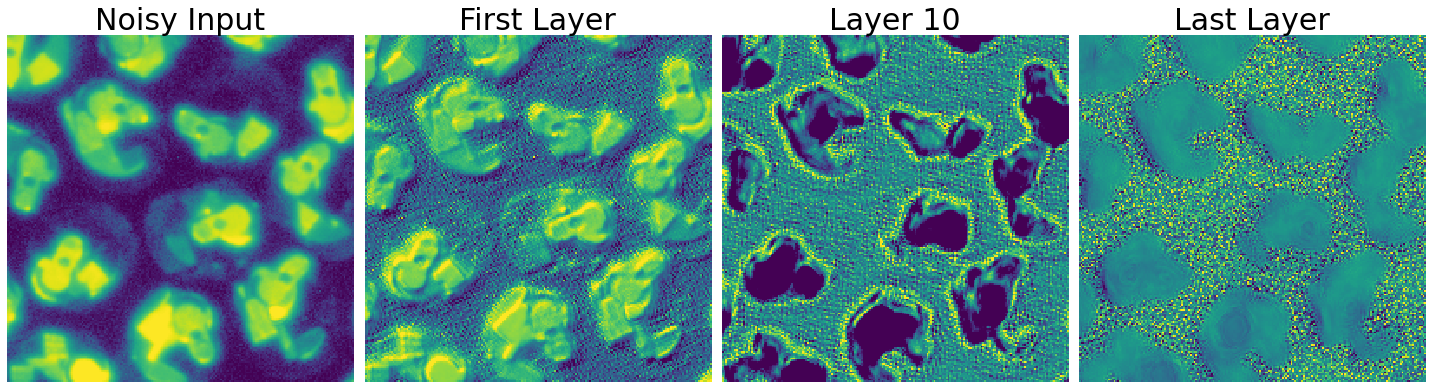

In [3]:
def plot_intermediate_layers(model, sample, weights_dict, size, x_start, y_start):
    
    model = model()
    model.load_state_dict(weights_dict)
    model.eval();
    output = model(sample)
    
    output0 = model.layers[0](sample)
    output1 = model.layers[1](output0)
    output2 = model.layers[2](output1)
    output3 = model.layers[3](output2)
    output4 = model.layers[4](output3)
    output5 = model.layers[5](output4)
    output6 = model.layers[6](output5)
    output7 = model.layers[7](output6)
    output8 = model.layers[8](output7)
    output9 = model.layers[9](output8)
    output10 = model.layers[10](output9)
    output11 = model.layers[11](output10)
    output12 = model.layers[12](output11)
    output13 = model.layers[13](output12)
    output14 = model.layers[14](output13)
    output15 = model.layers[15](output14)
    output16 = model.layers[16](output15)
    output17 = model.layers[17](output16)
    output18 = model.layers[18](output17)
    output19 = model.layers[19](output18)
    
    fig, ax = plt.subplots(1, 4, figsize=(20,16))
    vmin, vmax = np.percentile(sample[0][0][y_start:y_start+size, x_start:x_start+size], (1,99))
    vmin_first, vmax_first = np.percentile(output0[0][0][y_start:y_start+size, x_start:x_start+size].detach().numpy(), (1,99))
    vmin_mid, vmax_mid = np.percentile(output10[0][0][y_start:y_start+size, x_start:x_start+size].detach().numpy(), (1,99))
    vmin_last, vmax_last = np.percentile(output19[0][0][y_start:y_start+size, x_start:x_start+size].detach().numpy(), (1,99))


    ax[0].imshow(sample[0][0][y_start:y_start+size, x_start:x_start+size], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[0].set_title('Noisy Input', fontsize=30)
    ax[0].axis('off')
    ax[1].imshow(output0[0][0][y_start:y_start+size, x_start:x_start+size].detach().numpy(), vmin=vmin_first, vmax=vmax_first, origin='lower', interpolation='none')
    ax[1].set_title('First Layer', fontsize=30)
    ax[1].axis('off')
    ax[2].imshow(output10[0][0][y_start:y_start+size, x_start:x_start+size].detach().numpy(), vmin=vmin_mid, vmax=vmax_mid, origin='lower', interpolation='none')
    ax[2].set_title('Layer 10', fontsize=30)
    ax[2].axis('off')
    ax[3].imshow(output19[0][0][y_start:y_start+size, x_start:x_start+size].detach().numpy(), vmin=vmin_last, vmax=vmax_last, origin='lower', interpolation='none')
    ax[3].set_title('Last Layer', fontsize=30)
    ax[3].axis('off')
    
    fig.tight_layout()
    # plt.figsave('Intermediate feature maps')
    plt.show()
    

    
plot_intermediate_layers(model=DnCNN_B, sample=samp_6k, weights_dict=weights, size=200, x_start=500, y_start=500)

In [ ]:
model = DnCNN_B()
model.load_state_dict(weights)
model.eval();
    
%timeit output = model(sample_6k)

In [ ]:
denoised = samp_6k[0][0][500:700,500:700] - output19[0][0][500:700,500:700]
plt.imshow(denoised.detach().numpy())

In [ ]:
def focalplane_comparison(raw_data, afterburner, torch_full, np_full):
    """
    Creates 3x3 grid of 3 different pairings between the 3 different
    denoising approaches. (ie. full image passes with no overlapping
    regions implemented in PyTorch and NumPy, as well as, PyTorch
    implementation of the afterburner function, which has multiple 
    overlapping regions to account for artifacts that could crop up
    when tiling inference patches).
    
    These pairs are:
        1. PyTorch full pass vs. Numpy full pass
        2. PyTorch Afterburner vs. Numpy full pass
        3. PyTorch Afterburner vs. PyTorch full pass
    """
    
    after_torch = afterburner - torch_full
    after_np = afterburner - np_full
    torch_np = torch_full - np_full


    fig, ax = plt.subplots(3, 3, figsize=(26, 22))
    
    # For non-residual FVC images
    vmin, vmax = np.percentile(afterburner, (1,99))
    # For residuals
    vmax_resid = np.percentile(np.abs((raw_data[1][0][0] - raw_data[0][0][0])), (90))
    vmin_resid = -vmax_resid

    # Comparing pytorch denoised vs. numpy denoised
    ax[0,0].imshow(torch_full[0][0][0], vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[0,0].axis('off')
    ax[0,0].set_title('PyTorch No-Overlap',fontsize=28) 
    ax[0,1].imshow(np_full[0][0], vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[0,1].axis('off')
    ax[0,1].set_title('NumPy No-Overlap',fontsize=28) 
    ax[0,2].imshow(torch_np[0][0][0], vmin=vmin_resid, vmax=vmax_resid, cmap='bwr', origin='upper', interpolation='none')
    ax[0,2].axis('off')
    ax[0,2].set_title('PyTorch No-Overlap - Numpy No-Overlap', fontsize=28)
    
     # Comparing pytorch afterburner vs. numpy denoised
    ax[1,0].imshow(afterburner[0][0], vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[1,0].axis('off')
    ax[1,0].set_title('PyTorch Afterburner',fontsize=28) 
    ax[1,1].imshow(np_full[0][0],vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[1,1].axis('off')
    ax[1,1].set_title('NumPy No-Overlap',fontsize=28) 
    ax[1,2].imshow(after_np[0][0], vmin=vmin_resid, vmax=vmax_resid, cmap='bwr', origin='upper', interpolation='none')
    ax[1,2].axis('off')
    ax[1,2].set_title('PyTorch Afterburner - Numpy No-Overlap Denoised', fontsize=28)
    
     # Comparing pytorch afterburner vs. pytorch denoised
    ax[2,0].imshow(afterburner[0][0], vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[2,0].axis('off')
    ax[2,0].set_title('PyTorch Afterburner',fontsize=28) 
    ax[2,1].imshow(torch_full[0][0][0], vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[2,1].axis('off')
    ax[2,1].set_title('PyTorch No-Overlap',fontsize=28) 
    ax[2,2].imshow(after_torch[0][0][0], vmin=vmin_resid, vmax=vmax_resid, cmap='bwr', origin='upper', interpolation='none')
    ax[2,2].axis('off')
    ax[2,2].set_title('PyTorch Afterburner - PyTorch No-Overlap Denoised', fontsize=28)
    
    fig.tight_layout()
    
focalplane_comparison(raw_data=test_data,
                      afterburner=torch_afterburner,
                      torch_full=torch_denoised_2k,
                      np_full=np_denoised_2k)